# Assignment 4
## Econ 8310 - Business Forecasting

This assignment will make use of the bayesian statistical models covered in Lessons 10 to 12.

A/B Testing is a critical concept in data science, and for many companies one of the most relevant applications of data-driven decision-making. In order to improve product offerings, marketing campaigns, user interfaces, and many other user-facing interactions, scientists and engineers create experiments to determine the efficacy of proposed changes. Users are then randomly assigned to either the treatment or control group, and their behavior is recorded.
If the changes that the treatment group is exposed to can be measured to have a benefit in the metric of interest, then those changes are scaled up and rolled out to across all interactions.
Below is a short video detailing the A/B Testing process, in case you want to learn a bit more:
[https://youtu.be/DUNk4GPZ9bw](https://youtu.be/DUNk4GPZ9bw)

For this assignment, you will use an A/B test data set, which was pulled from the Kaggle website (https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing). I have added the data from the page into Codio for you. It can be found in the cookie_cats.csv file in the file tree. It can also be found at [https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv](https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv)

The variables are defined as follows:

| Variable Name  | Definition |
|----------------|----|
| userid         | A unique number that identifies each player  |
| version        | Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40) |
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install.  |
| retention1     | Did the player come back and play 1 day after installing?     |
| retention7     | Did the player come back and play 7 days after installing?    |               

### The questions

You will be asked to answer the following questions in a small quiz on Canvas:
1. What was the effect of moving the gate from level 30 to level 40 on 1-day retention rates?
2. What was the effect of moving the gate from level 30 to level 40 on 7-day retention rates?
3. What was the biggest challenge for you in completing this assignment?

You will also be asked to submit a URL to your forked GitHub repository containing your code used to answer these questions.


Average Retention Rates by Version:
         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000


Output()

Output()

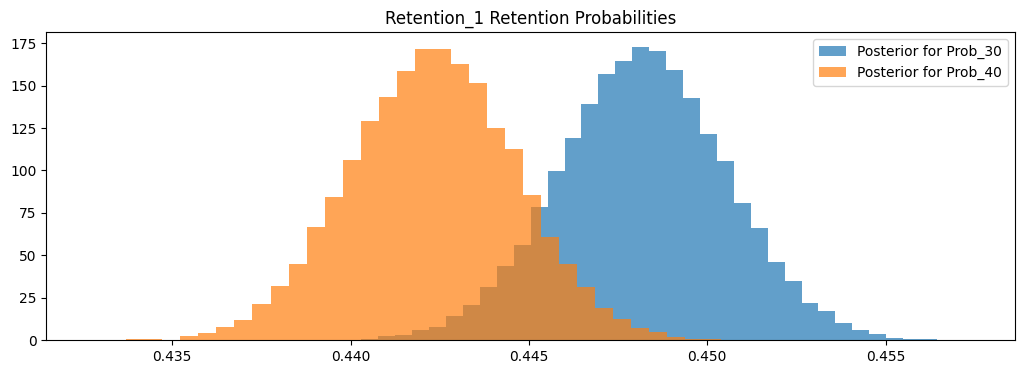

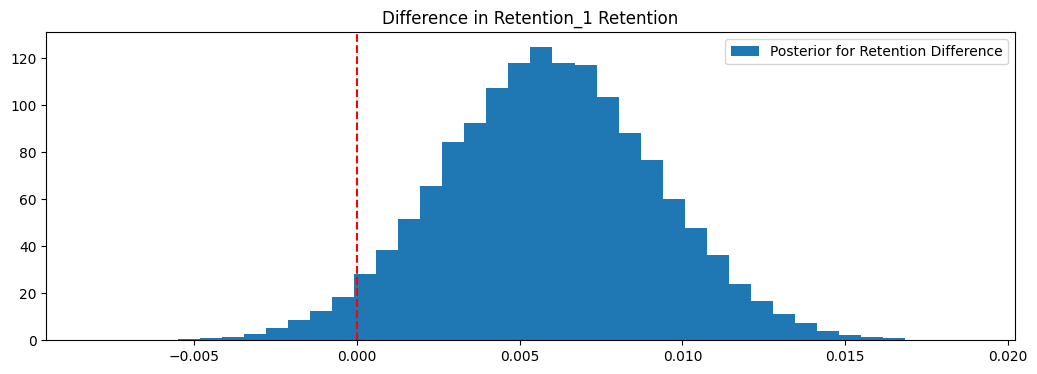


Retention_1 Retention Analysis Summary:
                       mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
prob_30_retention_1   0.448  0.002     0.444      0.453        0.0      0.0   
prob_40_retention_1   0.442  0.002     0.438      0.447        0.0      0.0   
retention_difference  0.006  0.003    -0.000      0.013        0.0      0.0   

                      ess_bulk  ess_tail  r_hat  
prob_30_retention_1    41898.0   29383.0    1.0  
prob_40_retention_1    43211.0   29997.0    1.0  
retention_difference   43101.0   29547.0    1.0  

Probability that Gate_30 is Superior: 96.34%


Output()

Output()

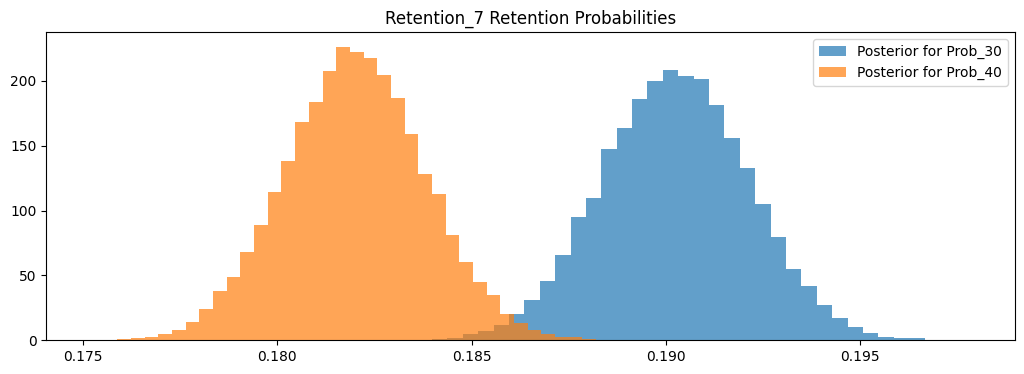

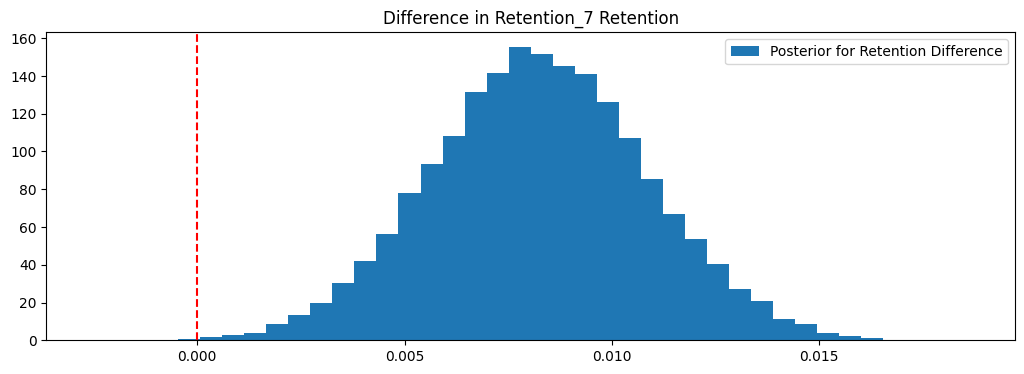


Retention_7 Retention Analysis Summary:
                       mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
prob_30_retention_7   0.190  0.002     0.187      0.194        0.0      0.0   
prob_40_retention_7   0.182  0.002     0.178      0.185        0.0      0.0   
retention_difference  0.008  0.003     0.003      0.013        0.0      0.0   

                      ess_bulk  ess_tail  r_hat  
prob_30_retention_7    39501.0   29234.0    1.0  
prob_40_retention_7    38127.0   30545.0    1.0  
retention_difference   39651.0   29097.0    1.0  

Probability that Gate_30 is Superior: 99.93%
Retention 1: Gate_30  Probability = 96.34%
Retention 7: Gate_30  Probability = 99.93%


In [3]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# URL for the dataset
data_url = "https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv"

# Load the dataset
game_data = pd.read_csv(data_url)



# Calculate and display retention rates
avg_retention = game_data.groupby('version')[['retention_1', 'retention_7']].mean()
print("\nAverage Retention Rates by Version:")
print(avg_retention)

def perform_bayesian_analysis(retention_metric):
    retention_version_30 = game_data[game_data['version'] == 'gate_30'][retention_metric]
    retention_version_40 = game_data[game_data['version'] == 'gate_40'][retention_metric]

    with pm.Model() as retention_model:
        prob_30 = pm.Uniform(f'prob_30_{retention_metric}', lower=0, upper=1)
        prob_40 = pm.Uniform(f'prob_40_{retention_metric}', lower=0, upper=1)

        obs_30 = pm.Bernoulli(f'obs_30_{retention_metric}', p=prob_30, observed=retention_version_30)
        obs_40 = pm.Bernoulli(f'obs_40_{retention_metric}', p=prob_40, observed=retention_version_40)

        retention_difference = pm.Deterministic('retention_difference', prob_30 - prob_40)

        retention_trace = pm.sample(20000, chains=2)

    return retention_trace

def visualize_and_summarize_results(trace, retention_metric):
    # Visualize posterior distributions for probabilities
    plt.figure(figsize=(12.5, 4))

    prob_30_samples = np.concatenate(trace.posterior[f'prob_30_{retention_metric}'].data[:, 1000:])
    prob_40_samples = np.concatenate(trace.posterior[f'prob_40_{retention_metric}'].data[:, 1000:])

    plt.hist(prob_30_samples, bins=40, label='Posterior for Prob_30', density=True, alpha=0.7)
    plt.hist(prob_40_samples, bins=40, label='Posterior for Prob_40', density=True, alpha=0.7)
    plt.title(f'{retention_metric.capitalize()} Retention Probabilities')
    plt.legend()
    plt.show()

    # Visualize posterior distribution for difference
    retention_diff_samples = np.concatenate(trace.posterior['retention_difference'].data[:, 1000:])

    plt.figure(figsize=(12.5, 4))
    plt.hist(retention_diff_samples, bins=40, label='Posterior for Retention Difference', density=True)
    plt.title(f'Difference in {retention_metric.capitalize()} Retention')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.legend()
    plt.show()

    # Display summary statistics
    print(f"\n{retention_metric.capitalize()} Retention Analysis Summary:")
    print(az.summary(trace, hdi_prob=0.95))

    # Calculate and display superiority probability
    prob_superiority = np.mean(retention_diff_samples > 0)
    print(f"\nProbability that Gate_30 is Superior: {prob_superiority:.2%}")

    return prob_superiority


results = {}
for metric in ['retention_1', 'retention_7']:
    trace = perform_bayesian_analysis(metric)
    prob_superiority = visualize_and_summarize_results(trace, metric)
    results[metric] = prob_superiority


for metric, probability in results.items():
    print(f"{metric.replace('_', ' ').capitalize()}: Gate_30  Probability = {probability:.2%}")
